In [1]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
real_data = "SOCOFing/Real"
altered_data = "SOCOFing/Altered"

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609

In [2]:
data = []
labels = []

df = pd.DataFrame(columns=['id', 'image', 'label'])
# load the real data and their labels
photos_names = os.listdir(real_data)

i = 0
for name in photos_names:
    img = cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE)
    data.append(img)
    labels.append(0)
    
    df.loc[i, 'id'] = name.split('_')[0]
    df.loc[i, 'image'] = img
    df.loc[i, 'label'] = 0
    i += 1

In [3]:
# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
for folder in dirs:
    photos_names = os.listdir(os.path.join(altered_data ,folder))
    for name in photos_names:
        img = cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE)
        data.append(img)
        labels.append(1)
        
        df.loc[i, 'id'] = name.split('_')[0]
        df.loc[i, 'image'] = img
        df.loc[i, 'label'] = 1
        i += 1
        

In [4]:
x = 96
y = 103

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['id'])
# train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

train_data = train['image'].values
train_labels = train['label'].values

test_data = test['image'].values
test_labels = test['label'].values

In [6]:
# resizing all the data to 103X96
# for i,image in enumerate(data):
#     data[i] = cv.resize(image ,(x,y))
    
# data = np.stack(data).reshape(-1 ,y ,x ,1)
# labels = np.stack(labels).reshape(-1 ,1)

# remake the code above for the train and test data
for i,image in enumerate(train_data):
    train_data[i] = cv.resize(image ,(x,y))

train_data = np.stack(train_data).reshape(-1 ,y ,x ,1)
train_labels = np.stack(train_labels).reshape(-1 ,1)

for i,image in enumerate(test_data):
    test_data[i] = cv.resize(image ,(x,y))

test_data = np.stack(test_data).reshape(-1 ,y ,x ,1)
test_labels = np.stack(test_labels).reshape(-1 ,1)

In [7]:
# printing shapes
train_data.shape ,train_labels.shape ,test_data.shape ,test_labels.shape

((44216, 103, 96, 1), (44216, 1), (11054, 103, 96, 1), (11054, 1))

In [23]:
# print the shape of the data for each image with different shape than expected
i = 0
for image in train_data:
    if image.shape != (y, x, 1):
        i += 1
print('images without the correct shape: ', i)

images without the correct shape:  0


[1]


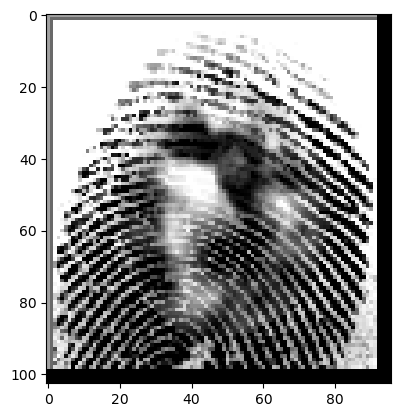

In [24]:
# visualization of 1 image from train data
import matplotlib.pyplot as plt
print(train_labels[0])
plt.imshow(train_data[0], cmap='gray')
plt.show()

In [8]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

### Using Cross Entropy loss

In [11]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
1106/1106 [==============================] - 39s 30ms/step - loss: 0.5237 - accuracy: 0.9005 - val_loss: 0.1904 - val_accuracy: 0.9110
Epoch 2/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1785 - accuracy: 0.9177 - val_loss: 0.1847 - val_accuracy: 0.9167
Epoch 3/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1684 - accuracy: 0.9228 - val_loss: 0.1988 - val_accuracy: 0.9043
Epoch 4/10
1106/1106 [==============================] - 35s 31ms/step - loss: 0.1575 - accuracy: 0.9273 - val_loss: 0.1772 - val_accuracy: 0.9181
Epoch 5/10
1106/1106 [==============================] - 35s 32ms/step - loss: 0.1489 - accuracy: 0.9338 - val_loss: 0.1756 - val_accuracy: 0.9213
Epoch 6/10
1106/1106 [==============================] - 36s 33ms/step - loss: 0.1407 - accuracy: 0.9358 - val_loss: 0.1732 - val_accuracy: 0.9211
Epoch 7/10
1106/1106 [==============================] - 39s 35ms/step - loss: 0.1319 - accuracy: 0.9402 - val_loss: 0.1726 -

In [12]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 10s 24ms/step
Balanced Accuracy: 0.8139547184004352
Confusion Matrix: 
[[ 820  390]
 [ 490 9354]]
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1210
           1       0.96      0.95      0.96      9844

    accuracy                           0.92     11054
   macro avg       0.79      0.81      0.80     11054
weighted avg       0.92      0.92      0.92     11054



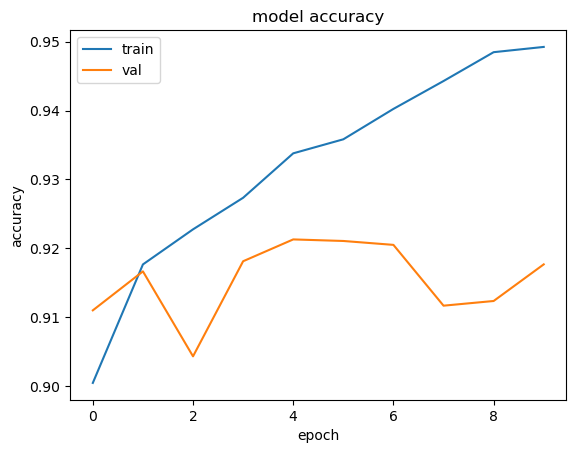

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Accuracy metric

In [11]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1106/1106 [==============================] - 43s 31ms/step - loss: 0.5158 - binary_accuracy: 0.8992 - val_loss: 0.1850 - val_binary_accuracy: 0.9188
Epoch 2/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1760 - binary_accuracy: 0.9199 - val_loss: 0.1884 - val_binary_accuracy: 0.9126
Epoch 3/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1664 - binary_accuracy: 0.9239 - val_loss: 0.1751 - val_binary_accuracy: 0.9205
Epoch 4/10
1106/1106 [==============================] - 33s 30ms/step - loss: 0.1608 - binary_accuracy: 0.9272 - val_loss: 0.1795 - val_binary_accuracy: 0.9167
Epoch 5/10
1106/1106 [==============================] - 35s 31ms/step - loss: 0.1547 - binary_accuracy: 0.9292 - val_loss: 0.1786 - val_binary_accuracy: 0.9206
Epoch 6/10
1106/1106 [==============================] - 38s 35ms/step - loss: 0.1458 - binary_accuracy: 0.9344 - val_loss: 0.1714 - val_binary_accuracy: 0.9222
Epoch 7/10
1106/1106 [==================

In [14]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 7s 21ms/step
Balanced Accuracy: 0.7419093226230015
Confusion Matrix: 
[[ 625  585]
 [ 322 9522]]
              precision    recall  f1-score   support

           0       0.66      0.52      0.58      1210
           1       0.94      0.97      0.95      9844

    accuracy                           0.92     11054
   macro avg       0.80      0.74      0.77     11054
weighted avg       0.91      0.92      0.91     11054



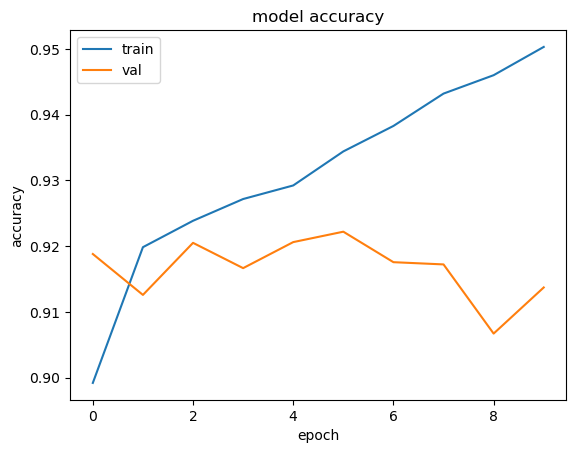

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Image Random Flip

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Input, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom, RandomCrop
import tensorflow as tf

# Input layer with the shape of your data
input_tensor = Input(shape=(y, x, 3))

# Data augmentation layers
x = RandomFlip("horizontal")(input_tensor)
x = RandomRotation(0.2)(x)  # Adjust the rotation range as needed
x = RandomZoom(0.2)(x)  # Adjust the zoom range as needed

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=input_tensor, outputs=predictions)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1106/1106 [==============================] - 185s 160ms/step - loss: 0.2326 - binary_accuracy: 0.8877 - val_loss: 0.0767 - val_binary_accuracy: 0.8735
Epoch 2/10
1106/1106 [==============================] - 170s 154ms/step - loss: 0.0559 - binary_accuracy: 0.9055 - val_loss: 0.1513 - val_binary_accuracy: 0.6684
Epoch 3/10
1106/1106 [==============================] - 169s 153ms/step - loss: 0.0555 - binary_accuracy: 0.9050 - val_loss: 0.0692 - val_binary_accuracy: 0.8790
Epoch 4/10
1106/1106 [==============================] - 169s 153ms/step - loss: 0.0540 - binary_accuracy: 0.9079 - val_loss: 0.0571 - val_binary_accuracy: 0.9055
Epoch 5/10
1106/1106 [==============================] - 169s 153ms/step - loss: 0.0550 - binary_accuracy: 0.9065 - val_loss: 0.0622 - val_binary_accuracy: 0.8936
Epoch 6/10
1106/1106 [==============================] - 169s 152ms/step - loss: 0.0546 - binary_accuracy: 0.9069 - val_loss: 0.0586 - val_binary_accuracy: 0.9011
Epoch 7/10
1106/1106 [======

In [10]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 9s 24ms/step
Balanced Accuracy: 0.8486874582327281
Confusion Matrix: 
[[1040  170]
 [1596 8248]]
              precision    recall  f1-score   support

           0       0.39      0.86      0.54      1210
           1       0.98      0.84      0.90      9844

    accuracy                           0.84     11054
   macro avg       0.69      0.85      0.72     11054
weighted avg       0.92      0.84      0.86     11054



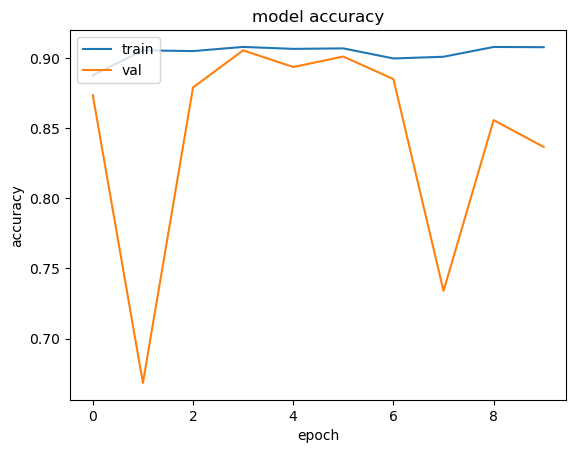

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Focal loss

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom


base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [10]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
553/553 [==============================] - 40s 63ms/step - loss: 0.6053 - binary_accuracy: 0.8852 - val_loss: 0.0672 - val_binary_accuracy: 0.8876
Epoch 2/10
553/553 [==============================] - 35s 63ms/step - loss: 0.0483 - binary_accuracy: 0.9178 - val_loss: 0.0514 - val_binary_accuracy: 0.9121
Epoch 3/10
553/553 [==============================] - 34s 62ms/step - loss: 0.0419 - binary_accuracy: 0.9266 - val_loss: 0.0466 - val_binary_accuracy: 0.9186
Epoch 4/10
553/553 [==============================] - 33s 60ms/step - loss: 0.0395 - binary_accuracy: 0.9307 - val_loss: 0.0500 - val_binary_accuracy: 0.9142
Epoch 5/10
553/553 [==============================] - 33s 60ms/step - loss: 0.0373 - binary_accuracy: 0.9345 - val_loss: 0.0482 - val_binary_accuracy: 0.9159
Epoch 6/10
553/553 [==============================] - 33s 60ms/step - loss: 0.0354 - binary_accuracy: 0.9386 - val_loss: 0.0559 - val_binary_accuracy: 0.9154
Epoch 7/10
553/553 [==============================] 

In [12]:
y_pred = model.predict(test_data_3)

346/346 [==============================] - 10s 27ms/step


In [13]:
a= np.rint(y_pred)

unique, counts = np.unique(a, return_counts=True)

dict(zip(unique, counts))

{0.0: 1132, 1.0: 9922}

In [14]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred)))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

0.7761301929941803
Confusion Matrix: 
[[ 719  491]
 [ 413 9431]]
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      1210
           1       0.95      0.96      0.95      9844

    accuracy                           0.92     11054
   macro avg       0.79      0.78      0.78     11054
weighted avg       0.92      0.92      0.92     11054



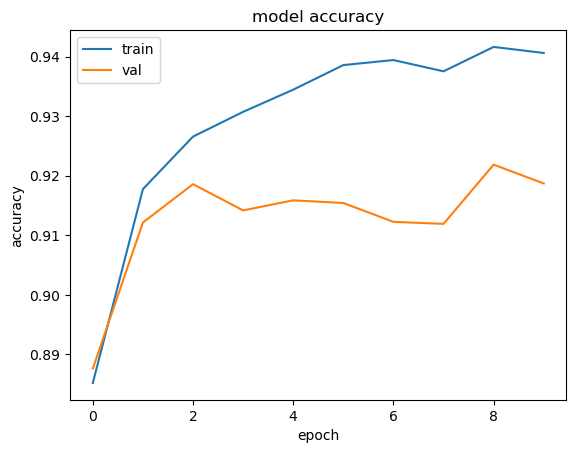

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Balanced Classes

In [2]:
import random

data = []
labels = []

df = pd.DataFrame(columns=['id', 'image', 'label'])
# load the real data and their labels
photos_names = os.listdir(real_data)

i = 0
for name in photos_names:
    img = cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE)
    data.append(img)
    labels.append(0)
    
    df.loc[i, 'id'] = name.split('_')[0]
    df.loc[i, 'image'] = img
    df.loc[i, 'label'] = 0
    i += 1

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
limit = int((len(data))/len(dirs))

for folder in dirs:
    dir_list = os.listdir(os.path.join(altered_data ,folder))
    photos_names = random.choices(population=dir_list, k=limit)
    for name in photos_names:
        img = cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE)
        data.append(img)
        labels.append(1)
        
        df.loc[i, 'id'] = name.split('_')[0]
        df.loc[i, 'image'] = img
        df.loc[i, 'label'] = 1
        i += 1
        

x = 96
y = 103

train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['id'])
# train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

train_data = train['image'].values
train_labels = train['label'].values

test_data = test['image'].values
test_labels = test['label'].values


# resizing all the data to 103X96
# for i,image in enumerate(data):
#     data[i] = cv.resize(image ,(x,y))
    
# data = np.stack(data).reshape(-1 ,y ,x ,1)
# labels = np.stack(labels).reshape(-1 ,1)

# remake the code above for the train and test data
for i,image in enumerate(train_data):
    train_data[i] = cv.resize(image ,(x,y))

train_data = np.stack(train_data).reshape(-1 ,y ,x ,1)
train_labels = np.stack(train_labels).reshape(-1 ,1)

for i,image in enumerate(test_data):
    test_data[i] = cv.resize(image ,(x,y))

test_data = np.stack(test_data).reshape(-1 ,y ,x ,1)
test_labels = np.stack(test_labels).reshape(-1 ,1)

# printing shapes
train_data.shape ,train_labels.shape ,test_data.shape ,test_labels.shape

((9600, 103, 96, 1), (9600, 1), (2400, 103, 96, 1), (2400, 1))

In [3]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

In [4]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [5]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
240/240 [==============================] - 15s 42ms/step - loss: 1.1014 - binary_accuracy: 0.7984 - val_loss: 0.1769 - val_binary_accuracy: 0.8630
Epoch 2/10
240/240 [==============================] - 9s 37ms/step - loss: 0.1056 - binary_accuracy: 0.8783 - val_loss: 0.1051 - val_binary_accuracy: 0.8490
Epoch 3/10
240/240 [==============================] - 9s 36ms/step - loss: 0.0604 - binary_accuracy: 0.9087 - val_loss: 0.1549 - val_binary_accuracy: 0.8625
Epoch 4/10
240/240 [==============================] - 9s 36ms/step - loss: 0.0568 - binary_accuracy: 0.9112 - val_loss: 0.1647 - val_binary_accuracy: 0.7714
Epoch 5/10
240/240 [==============================] - 9s 37ms/step - loss: 0.0430 - binary_accuracy: 0.9357 - val_loss: 0.0883 - val_binary_accuracy: 0.8823
Epoch 6/10
240/240 [==============================] - 9s 39ms/step - loss: 0.0399 - binary_accuracy: 0.9398 - val_loss: 0.1140 - val_binary_accuracy: 0.8813
Epoch 7/10
240/240 [==============================] - 9s 

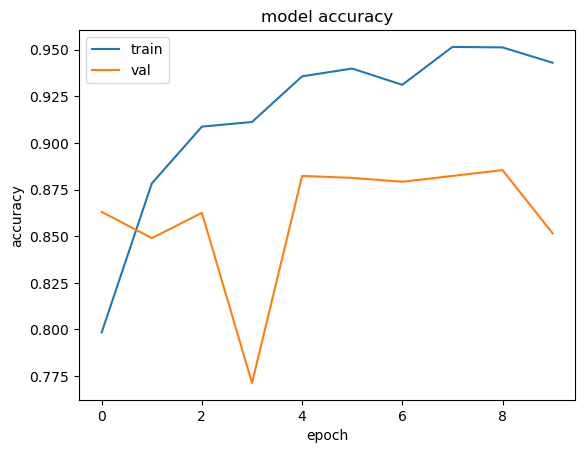

In [6]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(test_data_3)

print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

75/75 [==============================] - 3s 27ms/step
Balanced Accuracy: 0.8510150166852057
Confusion Matrix: 
[[ 921  239]
 [ 114 1126]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1160
           1       0.82      0.91      0.86      1240

    accuracy                           0.85      2400
   macro avg       0.86      0.85      0.85      2400
weighted avg       0.86      0.85      0.85      2400



In [8]:
model.save('socoF.h5') 